# นายณัฐดนัย บูรณะภักดี 62070241
# นายศุภวิชญ์ ศุภเสถียร 62070274

In [ ]:
import numpy as np
import pandas as pd
import json
import urllib
import urllib.request
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.under_sampling import RandomUnderSampler
import warnings
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Data

In [ ]:
!mkdir data 
!gdown --id 1H_SUCttk3bdXrNUa_HTBZYZylA650Rif -O /content/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx

Downloading...
From: https://drive.google.com/uc?id=1H_SUCttk3bdXrNUa_HTBZYZylA650Rif
To: /content/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx
100% 1.05M/1.05M [00:00<00:00, 69.1MB/s]


In [ ]:
data= pd.read_excel('/content/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [ ]:
#มีข้อมูลทั้งหมด 1925 แถว เเละมี feature ทั้งหมด 229 คอลัมน์
data 

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

In [ ]:
data.shape 

(1925, 231)

In [ ]:
data.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [ ]:
data.isnull().sum()

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64

# Data Preparation

In [ ]:
#เลือก feature ที่เป็น categorical ที่ไม่มีค่า null
data = data[data['AGE_ABOVE65'].notna()]
data = data[data['AGE_PERCENTIL'].notna()]
data = data[data['GENDER'].notna()]
data = data[data['DISEASE GROUPING 1'].notna()]
data = data[data['DISEASE GROUPING 2'].notna()]
data = data[data['DISEASE GROUPING 3'].notna()]
data = data[data['DISEASE GROUPING 4'].notna()]
data = data[data['DISEASE GROUPING 5'].notna()]
data = data[data['DISEASE GROUPING 6'].notna()]
data = data[data['HTN'].notna()]
data = data[data['IMMUNOCOMPROMISED'].notna()]
data = data[data['OTHER'].notna()]
data = data[data['WINDOW'].notna()]

In [ ]:
df_model = data.reset_index(drop=True)

In [ ]:
#Convert categorical variable to numerical variable by label encoding
win_en = {'WINDOW': { '0-2':1, '2-4':2,'4-6':3,'6-12':4, 'ABOVE_12':5}}
df_model.replace(win_en, inplace=True)
age_en = {'AGE_PERCENTIL':{'10th':1, '20th':1, '30th':1 , '40th':2, '50th':2, '60th':2, '70th':2, '80th':3,'90th':3, 'Above 90th':3}}
df_model.replace(age_en, inplace=True)

In [ ]:
#แทนค่าใน feature ที่เป็น numerical ด้วย median ของค่านั้น
df_model = df_model.fillna(df_model.mean())

In [ ]:
# เช็คว่ามีค่าว่างไหม
df_model.isnull().sum().sum()

0

# Feature Extraction

In [ ]:
# ดรอปคอลัมน์ PATIENT_VISIT_IDENTIFIER เพราะไม่มีความจำเป็นในการใช้งาน
df_model.drop( ['PATIENT_VISIT_IDENTIFIER'], axis = 1, inplace = True) 

In [ ]:
df_model = df_model[df_model.columns.drop(list(df_model.filter(regex='DIFF')))] #ลบcolumn ค่า DIFF ของแต่ละ feature ออกเนื่องจากไม่ได้ใช้งาน 
df_model

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,...,TGP_MIN,TGP_MAX,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
0,1,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.528527,0.528527,0.528527,0.528527,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.310924,-0.310924,-0.310924,-0.310924,-0.311845,-0.311845,-0.311845,-0.311845,-0.945928,-0.945928,-0.945928,-0.945928,-0.994424,-0.994424,-0.994424,-0.994424,...,-0.982156,-0.982156,-0.822280,-0.822280,-0.822280,-0.822280,-0.830181,-0.830181,-0.830181,-0.830181,-0.954177,-0.954177,-0.954177,-0.954177,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.000000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,1,0
1,1,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.528527,0.528527,0.528527,0.528527,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.310924,-0.310924,-0.310924,-0.310924,-0.311845,-0.311845,-0.311845,-0.311845,-0.945928,-0.945928,-0.945928,-0.945928,-0.994424,-0.994424,-0.994424,-0.994424,...,-0.982156,-0.982156,-0.822280,-0.822280,-0.822280,-0.822280,-0.830181,-0.830181,-0.830181,-0.830181,-0.954177,-0.954177,-0.954177,-0.954177,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.000000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,2,0
2,1,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.990854,-0.990854,-0.825613,-0.825613,-0.825613,-0.825613,-0.836145,-0.836145,-0.836145,-0.836145,-0.994912,-0.994912,-0.994912,-0.994912,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,3,0
3,1,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.528527,0.528527,0.528527,0.528527,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.310924,-0.310924,-0.310924,-0.310924,-0.311845,-0.311845,-0.311845,-0.311845,-0.945928,-0.945928,-0.945928,-0.945928,-0.994424,-0.994424,-0.994424,-0.994424,...,-0.982156,-0.982156,-0.822280,-0.822280,-0.822280,-0.822280,-0.830181,-0.830181,-0.830181,-0.830181,-0.954177,-0.954177,-0.954177,-0.954177,-0.093631,-0.332600,-0.264701,-0.438754,-0.107143,0.736842,-0.097790,-0.338468,-0.268632,-0.435121,-0.107143,0.736842,-0.040855,-0.207812,-0.26499

# Feature Selection

In [ ]:
fea_select = df_model.corr(method='pearson')
cor_target = abs(fea_select["ICU"])
#นำ feature ที่มีค่า Correlation น้อยกว่า 0.2 ออก
features = cor_target[cor_target>0.2]
features.sort_values(ascending=False) 

ICU                               1.000000
RESPIRATORY_RATE_MAX              0.504777
RESPIRATORY_RATE_MEAN             0.367219
BLOODPRESSURE_DIASTOLIC_MIN       0.355857
LACTATE_MEDIAN                    0.339604
LACTATE_MEAN                      0.339604
LACTATE_MAX                       0.339604
LACTATE_MIN                       0.339604
RESPIRATORY_RATE_MEDIAN           0.332636
BLOODPRESSURE_SISTOLIC_MAX        0.332621
WINDOW                            0.330015
TEMPERATURE_MIN                   0.252401
BE_VENOUS_MEDIAN                  0.222364
BE_VENOUS_MEAN                    0.222364
BE_VENOUS_MIN                     0.222364
BE_VENOUS_MAX                     0.222364
BLOODPRESSURE_DIASTOLIC_MEDIAN    0.218818
BLOODPRESSURE_DIASTOLIC_MEAN      0.215047
HEART_RATE_MAX                    0.212023
HEMOGLOBIN_MEDIAN                 0.211245
HEMOGLOBIN_MEAN                   0.211245
HEMOGLOBIN_MIN                    0.211245
HEMOGLOBIN_MAX                    0.211245
AGE_ABOVE65

In [ ]:
new_feature = list(features.index.values) #ตั้งชื่อคอลลัมน์ใหม่

In [ ]:
df_model = df_model[new_feature]

In [ ]:
df_model.shape

(1920, 34)

# Resampling Data

In [ ]:
#ข้อมูลมีค่าไม่สมดุลกันจึงทำการแบ่งข้อมูลใหม่
df_model['ICU'].value_counts() 

0    1405
1     515
Name: ICU, dtype: int64

In [ ]:
# X คือ features y คือ ผู้ป่วยรับการรักษาในห้องฉุกเฉินหรือไม่(0 = ไม่, 1 = ใช่ )
X = df_model.drop('ICU', axis=1) 
y = df_model['ICU']

In [ ]:
column_name = X.columns 

In [ ]:
X = df_model.iloc[:, 0:33].values
y = df_model.iloc[:, -1].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
sampling_size = {0:1405 , 1:1405} #เเเบ่ง ขนาด เป็น 2410 row โดยเเบ่งโดยใช้ RandomOverSampler
rus = RandomOverSampler(sampling_strategy=sampling_size,random_state=42)
X_resampled , y_resampled = rus.fit_resample(X,y)
X_resampled = pd.DataFrame(X_resampled, columns=column_name)
y_resampled = pd.DataFrame(y_resampled, columns=['ICU'])

In [ ]:
y_resampled['ICU'].value_counts() #ขนาดกลุ่มข้อมูลใหม่

1    1405
0    1405
Name: ICU, dtype: int64

เมื่อข้อมูลพร้อมใช้งานแล้วทำการแบ่งข้อมูลเป็น X,y

In [ ]:
#เเบ่ง data เป็น train กับ test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0) 

# Modeling

In [ ]:
# สร้าง list สำหรับเก็บข้อมูลในการทำ visualize
Modle_name, Acc_scr, F1_scr, Pre_scr, Re_scr, Tuning  = [],[],[],[],[],[]

## Decision Tree

In [ ]:
#define function
def decisionTree(X_train, y_train,X_test,y_test):
    decision_tree=DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    test_prediction = decision_tree.predict(X_test)


    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Decision Tree')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('No')
    #Sum
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

In [ ]:
decisionTree(X_train, y_train,X_test,y_test)

Accuracy score: 0.86
Precision score: 0.8633879781
Recall score: 0.8610354223
F1 score: 0.8622100955


In [ ]:
def decison_hyper(X_train, y_train):
    model = DecisionTreeClassifier()
    criterion = ['gini', 'entropy']
    min_samples_split = [2,4,6,8,10,12]
    min_samples_leaf = [1,2,3,4,5,6,7,8,9,10,11,12]
    max_depth = [1, 3, 5, 7, 10, 15, 20]
    max_features = [0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
    grid = dict(criterion=criterion, max_depth=max_depth
                , min_samples_split=min_samples_split
                , min_samples_leaf=min_samples_leaf
                , max_features=max_features)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
    global dt
    dt = grid_search.fit(X_train, y_train)

    print('Best',dt.best_params_)

In [ ]:
decison_hyper(X_train,y_train)

Best {'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
def decisionTree_tune(X_train, y_train,X_test,y_test):
    global decision_tree
    decision_tree=DecisionTreeClassifier(criterion=dt.best_params_['criterion']
                                         , max_depth = dt.best_params_['max_depth']
                                         ,min_samples_leaf= dt.best_params_['min_samples_leaf']
                                         ,min_samples_split=dt.best_params_['min_samples_split']
                                         ,max_features=dt.best_params_['max_features']) 
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    test_prediction = decision_tree.predict(X_test)

    sns.set_theme(style='white')
    plot_confusion_matrix(decision_tree, X_test, y_test) 
    plt.show()

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Decision Tree')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('Yes')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)


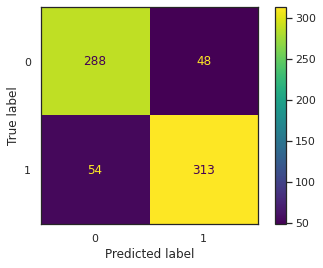

Accuracy score: 0.85
Precision score: 0.8670360111
Recall score: 0.8528610354
F1 score: 0.8598901099


In [ ]:
decisionTree_tune(X_train, y_train,X_test,y_test)

In [ ]:
# หา Feature Importance
fi_dt=pd.Series(decision_tree.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi_dt[0:20]

RESPIRATORY_RATE_MEAN             0.283606
RESPIRATORY_RATE_MAX              0.092874
BLOODPRESSURE_SISTOLIC_MAX        0.079848
BLOODPRESSURE_DIASTOLIC_MIN       0.074989
BLOODPRESSURE_DIASTOLIC_MEAN      0.064309
HEART_RATE_MAX                    0.060282
TEMPERATURE_MIN                   0.050827
WINDOW                            0.043904
LEUKOCYTES_MIN                    0.033956
OXYGEN_SATURATION_MAX             0.032251
BLOODPRESSURE_DIASTOLIC_MEDIAN    0.032245
AGE_PERCENTIL                     0.027285
LACTATE_MAX                       0.027071
RESPIRATORY_RATE_MEDIAN           0.025928
AGE_ABOVE65                       0.011921
LEUKOCYTES_MAX                    0.010640
LACTATE_MEAN                      0.010629
HEMOGLOBIN_MIN                    0.007783
BE_VENOUS_MAX                     0.004731
BE_VENOUS_MIN                     0.004693
dtype: float64

In [ ]:
dt_probs = decision_tree.predict_proba(X_test)
dt_probs = dt_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
print('Decision Tree: ROC AUC =%.3f' % (dt_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

Decision Tree: ROC AUC =0.891


## Random Forrest

In [ ]:
def random_forrest(X_train, y_train,X_test,y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    test_prediction = model.predict(X_test)

    test_acc = accuracy_score(test_prediction, y_test)

    
    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Random Forrest')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('No')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

In [ ]:
random_forrest(X_train, y_train,X_test,y_test)

Accuracy score: 0.79
Precision score: 0.8096590909
Recall score: 0.7765667575
F1 score: 0.7927677330


In [ ]:
def random_forrest_hyper(X_train, y_train):
  model = RandomForestClassifier()
  # กำหนด parameter ที่จะทำการทดสอบ
  n_estimators = [10, 100, 1000]
  max_features = ['sqrt', 'log2']
  grid = dict(n_estimators=n_estimators, max_features=max_features)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  grid_search = GridSearchCV(estimator=model, param_grid=grid
                             , cv=cv, scoring='accuracy'
                             ,error_score=0)
  global rf
  rf = grid_search.fit(X_train, y_train.values.ravel())
  print("Best using %s" % rf.best_params_)

In [ ]:
random_forrest_hyper(X_train, y_train)

Best using {'max_features': 'sqrt', 'n_estimators': 100}


In [ ]:
def random_forrest_tune(X_train, y_train,X_test,y_test):
    global random_forrest
    random_forrest=RandomForestClassifier(max_features=rf.best_params_['max_features']
                                          , n_estimators=rf.best_params_['n_estimators']) 
    random_forrest.fit(X_train, y_train.values.ravel())
    y_pred = random_forrest.predict(X_test)

    test_prediction = random_forrest.predict(X_test)

    sns.set_theme(style='white')
    plot_confusion_matrix(random_forrest, X_test, y_test) 
    plt.show()

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Random Forrest')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('Yes')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

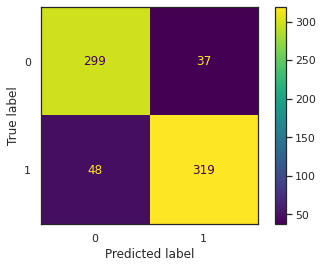

Accuracy score: 0.88
Precision score: 0.8960674157
Recall score: 0.8692098093
F1 score: 0.8824343015


In [ ]:
random_forrest_tune(X_train, y_train,X_test,y_test)

In [ ]:
rf_probs = random_forrest.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
print('Random Forrest: ROC AUC=%.3f' % (rf_auc))

Random Forrest: ROC AUC=0.953


In [ ]:
# หา Feature Importance
fi_rf=pd.Series(random_forrest.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi_rf[0:20]

RESPIRATORY_RATE_MEAN             0.120335
RESPIRATORY_RATE_MAX              0.103425
BLOODPRESSURE_DIASTOLIC_MIN       0.088346
BLOODPRESSURE_SISTOLIC_MAX        0.084756
RESPIRATORY_RATE_MEDIAN           0.082172
BLOODPRESSURE_DIASTOLIC_MEDIAN    0.062881
BLOODPRESSURE_DIASTOLIC_MEAN      0.054133
OXYGEN_SATURATION_MAX             0.049210
TEMPERATURE_MIN                   0.049133
HEART_RATE_MAX                    0.043478
WINDOW                            0.040876
AGE_PERCENTIL                     0.023942
LACTATE_MEDIAN                    0.016915
AGE_ABOVE65                       0.016748
LEUKOCYTES_MEAN                   0.016691
LACTATE_MEAN                      0.016383
LACTATE_MIN                       0.015808
LEUKOCYTES_MAX                    0.015796
LEUKOCYTES_MEDIAN                 0.014091
LEUKOCYTES_MIN                    0.013807
dtype: float64

## k-Nearest Neighbors

In [ ]:
def k_nearest_neighbor(X_train, y_train,X_test,y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    test_prediction = model.predict(X_test)

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('K-Nearest Neighbors')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('No')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

In [ ]:
k_nearest_neighbor(X_train, y_train,X_test,y_test)

Accuracy score: 0.79
Precision score: 0.8096590909
Recall score: 0.7765667575
F1 score: 0.7927677330


In [ ]:
def k_nearest_hyper(X_train, y_train):  
    model = KNeighborsClassifier()
    leaf_size = list(range(1,30))
    n_neighbors = list(range(1,20))
    p=[1,2]
    grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv
                               ,scoring='accuracy'
                               ,error_score=0)
    global knn
    knn = grid_search.fit(X_train, y_train.values.ravel())
    print("Best using %s" % knn.best_params_)

In [ ]:
k_nearest_hyper(X_train, y_train)

Best using {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}


In [ ]:
def k_nearest_neighbor_tune(X_train, y_train,X_test,y_test):
    global k_nearest
    k_nearest=KNeighborsClassifier(leaf_size=knn.best_params_['leaf_size']
                                   , n_neighbors=knn.best_params_['n_neighbors']
                                   , p=knn.best_params_['p']) 
    k_nearest.fit(X_train, y_train.values.ravel())
    y_pred = k_nearest.predict(X_test)

    test_prediction = k_nearest.predict(X_test)

    sns.set_theme(style='white')
    plot_confusion_matrix(k_nearest, X_test, y_test) 
    plt.show()

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('K-Nearest Neighbors')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('Yes')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

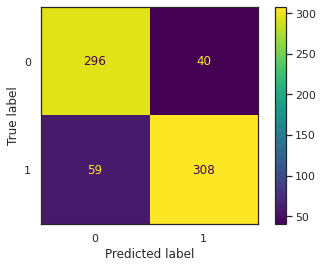

Accuracy score: 0.86
Precision score: 0.8850574713
Recall score: 0.8392370572
F1 score: 0.8615384615


In [ ]:
k_nearest_neighbor_tune(X_train, y_train,X_test,y_test)

In [ ]:
knn_probs = k_nearest.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
print('KNN: ROC AUC=%.3f' % (knn_auc))

KNN: ROC AUC=0.860


## Logistic Regression

In [ ]:
def logistic(X_train, y_train,X_test,y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    test_prediction = model.predict(X_test)

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Logistic Regression')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('No')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

In [ ]:
logistic(X_train, y_train,X_test,y_test)

Accuracy score: 0.76
Precision score: 0.8036253776
Recall score: 0.7247956403
F1 score: 0.7621776504


In [ ]:
def logistic_hyper(X_train, y_train):
  model = LogisticRegression()
  # กำหนด parameter ที่จะทำการทดสอบ
  solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
  penalty = ['l2']
  c_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
  tol = [1e-4,1e-3,1e-2]
  max_iter = [1500,2000,2500]
  grid = dict(solver=solvers,penalty=penalty,C=c_values,tol=tol,max_iter=max_iter)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  grid_search = GridSearchCV(estimator=model, param_grid=grid
                             , cv=cv, scoring='accuracy'
                             ,error_score=0)
  global lr
  lr = grid_search.fit(X_train, y_train.values.ravel())
  print("Best using %s" % lr.best_params_)

In [ ]:
logistic_hyper(X_train, y_train)

Best using {'C': 5, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}


In [ ]:
def logistic_tune(X_train, y_train,X_test,y_test):
    #นำ parameter มาใส่ใน classifier
    global logis
    logis =LogisticRegression(max_iter=lr.best_params_['max_iter']
                              ,  C=lr.best_params_['C']
                              , solver=lr.best_params_['solver'], 
                            tol=lr.best_params_['tol'])
    logis.fit(X_train, y_train.values.ravel())
    y_pred = logis.predict(X_test)

    sns.set_theme(style='white')
    plot_confusion_matrix(logis, X_test, y_test) 
    plt.show()

    test_prediction = logis.predict(X_test)

    test_acc = accuracy_score(test_prediction, y_test)

    f1 = f1_score(y_test, y_pred, average='binary')  
    p_score = precision_score(y_test, y_pred, average='binary')
    re_score = recall_score(y_test,y_pred ,average='binary')
    #Append list
    Modle_name.append('Logistic Regression')
    Acc_scr.append(test_acc)
    F1_scr.append(f1)
    Pre_scr.append(p_score)
    Re_scr.append(re_score)
    Tuning.append('Yes')
    #Sum 
    print("Accuracy score: %.2f" % test_acc)
    print('Precision score: %.10f' %p_score)
    print('Recall score: %.10f' %re_score)
    print('F1 score: %.10f'%f1)

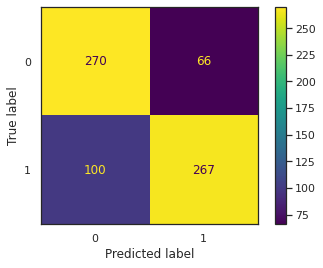

Accuracy score: 0.76
Precision score: 0.8018018018
Recall score: 0.7275204360
F1 score: 0.7628571429


In [ ]:
logistic_tune(X_train, y_train,X_test,y_test)

In [ ]:
lr_probs = logis.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))


Logistic: ROC AUC=0.844


# Data visualization

## Bar plot Acc,Precision,Recall,F1

In [ ]:
sum_viz = pd.DataFrame({'Model_Name':Modle_name, 'ACC_Score':Acc_scr, 'Precision_Score':Pre_scr, 'Recall_Score':Re_scr, 'F1_Score':F1_scr, 'Tuning':Tuning})

In [ ]:
sum_viz

,Model_Name,ACC_Score,Precision_Score,Recall_Score,F1_Score,Tuning
0,Decision Tree,0.856330,0.863388,0.861035,0.862210,No
1,Decision Tree,0.854908,0.867036,0.852861,0.859890,Yes
2,Random Forrest,0.788051,0.809659,0.776567,0.792768,No
3,Random Forrest,0.879090,0.896067,0.869210,0.882434,Yes
4,K-Nearest Neighbors,0.788051,0.809659,0.776567,0.792768,No
5,K-Nearest Neighbors,0.859175,0.885057,0.839237,0.861538,Yes
6,Logistic Regression,0.763869,0.803625,0.724796,0.762178,No
7,Logistic Regression,0.763869,0.801802,0.727520,0.762857,Yes


(0.75, 0.9)

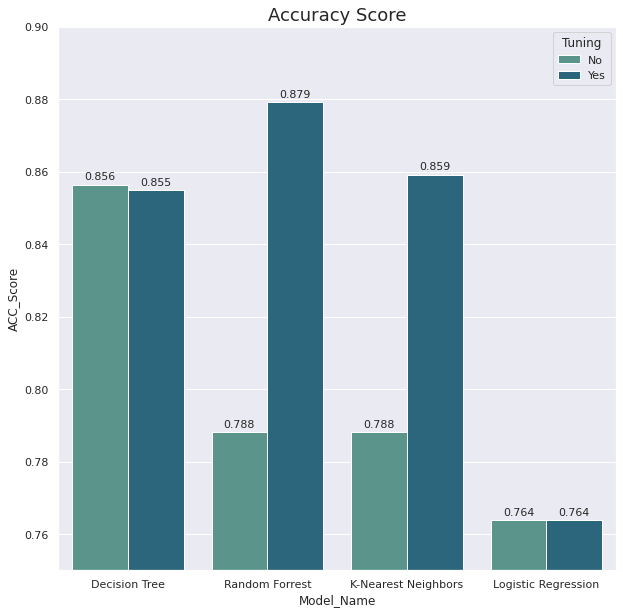

In [ ]:
sns.set_theme(style='darkgrid')
#กำหนดขนาดของกราฟ
countplt, ax = plt.subplots(figsize = (10,10))
#สร้างกราฟ Bar chart 
c_value = sns.barplot(x ='Model_Name', y='ACC_Score', hue='Tuning', data = sum_viz ,palette='crest',ax=ax)
#แสดง Value ในกราฟแต่ละแท่ง
for p in c_value.patches:
    c_value.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 8), 
                   textcoords = 'offset points', size = 11)
plt.title('Accuracy Score', size = 18)
plt.ylim(0.75,0.90)

(0.75, 0.92)

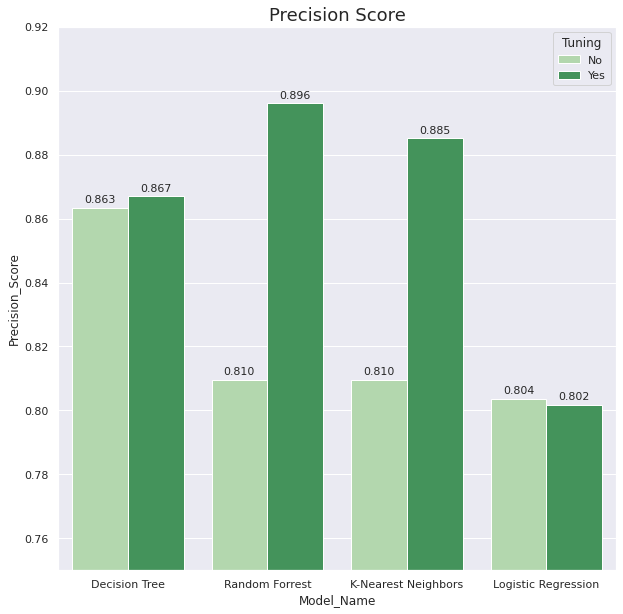

In [ ]:
#กำหนดขนาดของกราฟ
countplt, ax = plt.subplots(figsize = (10,10))
#สร้างกราฟ Bar chart 
c_value = sns.barplot(x ='Model_Name', y='Precision_Score', hue='Tuning', data = sum_viz ,palette='Greens',ax=ax)
#แสดง Value ในกราฟแต่ละแท่ง
for p in c_value.patches:
    c_value.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 8), 
                   textcoords = 'offset points', size = 11)
plt.title('Precision Score', size = 18)
plt.ylim(0.75,0.92)

(0.6, 0.9)

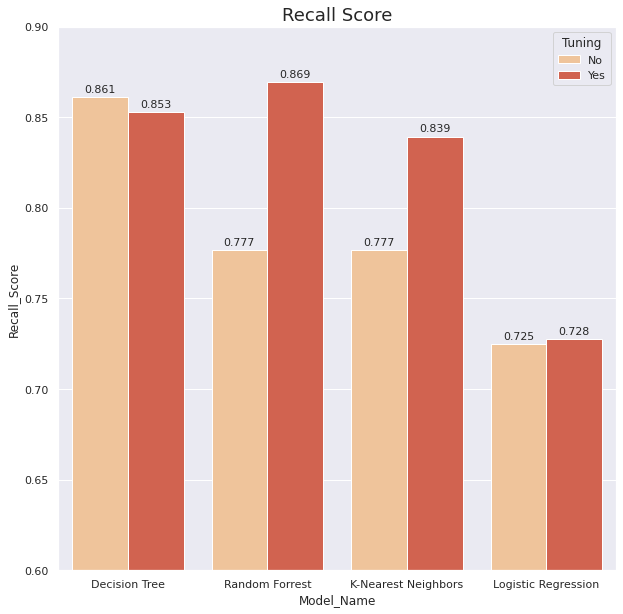

In [ ]:
#กำหนดขนาดของกราฟ
countplt, ax = plt.subplots(figsize = (10,10))
#สร้างกราฟ Bar chart 
c_value = sns.barplot(x ='Model_Name', y='Recall_Score', hue='Tuning', data = sum_viz ,palette='OrRd',ax=ax)
#แสดง Value ในกราฟแต่ละแท่ง
for p in c_value.patches:
    c_value.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 8), 
                   textcoords = 'offset points', size = 11)
plt.title('Recall Score', size = 18)
plt.ylim(0.6,0.90)

(0.7, 0.9)

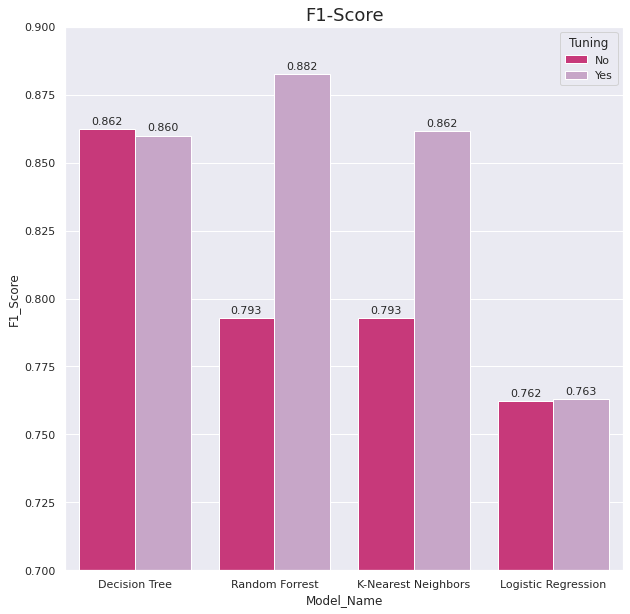

In [ ]:
#กำหนดขนาดของกราฟ
countplt, ax = plt.subplots(figsize = (10,10))
#สร้างกราฟ Bar chart 
c_value = sns.barplot(x ='Model_Name', y='F1_Score', hue='Tuning', data = sum_viz ,palette='PuRd_r',ax=ax)
#แสดง Value ในกราฟแต่ละแท่ง
for p in c_value.patches:
    c_value.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 8), 
                   textcoords = 'offset points', size = 11)
plt.title('F1-Score', size = 18)
plt.ylim(0.7,0.90)

## Auc Score

In [ ]:
curve_dt = 'DecisionTree ='+str(round(dt_auc,3)) 
curve_rf = 'RandomForrest='+str(round(rf_auc,3)) 
curve_knn = 'KNN='+str(round(knn_auc,3))
curve_lr = 'Logistic='+str(round(lr_auc,3))  

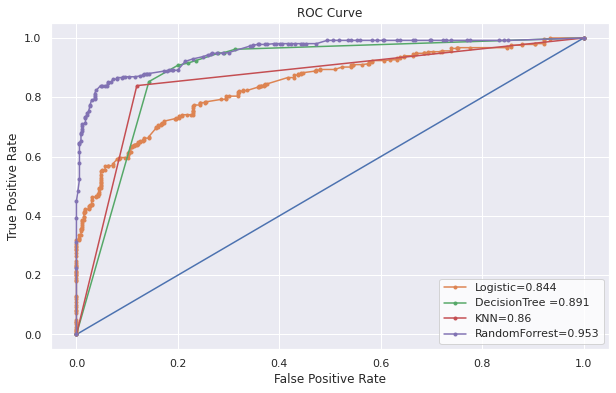

In [ ]:
plt.subplots(figsize = (10,6))
sns.set_theme(style='white')
pyplot.plot(ns_fpr, ns_tpr, marker='.',)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label=curve_lr)
pyplot.plot(dt_fpr, dt_tpr, marker='.', label=curve_dt)
pyplot.plot(knn_fpr, knn_tpr, marker='.', label=curve_knn)
pyplot.plot(rf_fpr, rf_tpr, marker='.', label=curve_rf)
pyplot.title('ROC Curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# สรุป

จากการเทียบค่า Accuracy score, Presicion score, F1 score และ ค่า Auc score พบว่า Random Forrest ให้ประสิทธิภาพที่สูงที่สุด

# Deployment

In [ ]:
!pip install colabcode
!pip install fastapi

     |████████████████████████████████| 745 kB 7.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 8.3 MB 16.7 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 396 kB 57.2 MB/s 
     |████████████████████████████████| 428 kB 55.3 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 129 kB 73.9 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 125 kB 77.9 MB/s 
     |████████████████████████████████| 124 kB 70.8 MB/s 
     |████████████████████████████████| 124 kB 58.2 MB/s 
     |████████████████████████████████| 122 kB 50.4 MB/s 
     |████████████████████████████████| 122 kB 58.5 MB/s 
     |████████████████████████████████| 122 kB 43.6 MB/s 
     |████████████████████████████████| 122 kB 47.4 MB/s 
     |███████████████████

     |████████████████████████████████| 51 kB 561 kB/s 
     |████████████████████████████████| 61 kB 269 kB/s 
     |████████████████████████████████| 10.1 MB 28.8 MB/s 


In [ ]:
from colabcode import ColabCode
from fastapi import FastAPI
import pickle
import logging

In [ ]:
model_feature = df_model[new_feature]

In [ ]:
def train_model(feature, target):
    model = RandomForestClassifier(max_features='log2',n_estimators=1000) #parameter ที่จูนมาแล้ว
    model.fit(feature, target)
    return model

In [ ]:
def deploy_model(file, data):
    feature = data.drop(['ICU'], axis=1)
    target = data['ICU']

    model = train_model(feature, target)
    data

    print("Save a trained model")
    print(file)
    with open(file,'wb') as f:
        pickle.dump(model, f)

In [ ]:
deploy_model('icu_train.plk', model_feature)

Save a trained model
icu_train.plk


In [ ]:
cc = ColabCode(port=12000, code=False) # ตั้งค่าport localhost
app = FastAPI(title="ICU predictor", description="Based on Random Forrest Classifier", version="1.0") #ตั้งชื่อ title ของ เว็บไซต์

In [ ]:
@app.on_event("startup")
def load_model():
  global model_to_pre
  model_to_pre = pickle.load(open("icu_train.plk", "rb")) #อ่านไฟล์plk ที่trainมา

@app.post("/api", tags=["prediction"])

async def get_predictions(
              AGE_ABOVE65: int=1 ,
              AGE_PERCENTIL: int= 2,
              BE_ARTERIAL_MEDIAN: float= -0.963433,
              BE_ARTERIAL_MEAN: float= -0.963433,
              BE_ARTERIAL_MIN: float= -0.963433,
              BE_ARTERIAL_MAX: float= -0.931121 ,
              BE_VENOUS_MEDIAN: float= -0.931121,
              BE_VENOUS_MEAN:float=-0.931121,
              BE_VENOUS_MIN:float=-0.931121,
              BE_VENOUS_MAX:float=-0.202472,
              HEMOGLOBIN_MEDIAN:float=-0.202472,
              HEMOGLOBIN_MEAN:float=-0.202472,
              HEMOGLOBIN_MIN:float=-0.202472,
              HEMOGLOBIN_MAX:float=0.267131,
              LACTATE_MEDIAN:float=0.267131, 
              LACTATE_MEAN:float=0.267131, 
              LACTATE_MIN:float=0.267131,
              LACTATE_MAX:float=-0.741266, 
              LEUKOCYTES_MEDIAN:float=-0.741266, 
              LEUKOCYTES_MEAN:float=-0.741266, 
              LEUKOCYTES_MIN:float=-0.741266,
              LEUKOCYTES_MAX:float=0.08642, 
              BLOODPRESSURE_DIASTOLIC_MEAN:float=-0.59322,
              RESPIRATORY_RATE_MEAN:float=0.08642, 
              BLOODPRESSURE_DIASTOLIC_MEDIAN:float=-0.586207,
              RESPIRATORY_RATE_MEDIAN:float=0.237113, 
              BLOODPRESSURE_DIASTOLIC_MIN:float=0.208791,
              TEMPERATURE_MIN:float=-0.208791,
              BLOODPRESSURE_SISTOLIC_MAX:float=-0.459459, 
              HEART_RATE_MAX:float=-0.432836,
              RESPIRATORY_RATE_MAX:float=-0.636364,
              OXYGEN_SATURATION_MAX:float=0.736842	, 
              WINDOW:int=1,
              ):
  try:	
    query_dict = {
              'AGE_ABOVE65':AGE_ABOVE65  ,
              'AGE_PERCENTIL':AGE_PERCENTIL  ,
              'BE_ARTERIAL_MEDIAN':BE_ARTERIAL_MEDIAN ,
              'BE_ARTERIAL_MEAN':BE_ARTERIAL_MEAN  ,
              'BE_ARTERIAL_MIN': BE_ARTERIAL_MIN ,
              'BE_ARTERIAL_MAX':BE_ARTERIAL_MAX   ,
              'BE_VENOUS_MEDIAN': BE_VENOUS_MEDIAN  ,
              'BE_VENOUS_MEAN':BE_VENOUS_MEAN,
              'BE_VENOUS_MIN':BE_VENOUS_MIN,
              'BE_VENOUS_MAX':BE_VENOUS_MAX,
              'HEMOGLOBIN_MEDIAN':HEMOGLOBIN_MEDIAN,
              'HEMOGLOBIN_MEAN':HEMOGLOBIN_MEAN,
              'HEMOGLOBIN_MIN':HEMOGLOBIN_MIN,
              'HEMOGLOBIN_MAX':HEMOGLOBIN_MAX,
              'LACTATE_MEDIAN':LACTATE_MEDIAN, 
              'LACTATE_MEAN':LACTATE_MEAN, 
              'LACTATE_MIN':LACTATE_MIN,
              'LACTATE_MAX':LACTATE_MAX, 
              'LEUKOCYTES_MEDIAN':LEUKOCYTES_MEDIAN, 
              'LEUKOCYTES_MEAN':LEUKOCYTES_MEAN, 
              'LEUKOCYTES_MIN':LEUKOCYTES_MIN,
              'LEUKOCYTES_MAX':LEUKOCYTES_MAX, 
              'BLOODPRESSURE_DIASTOLIC_MEAN':BLOODPRESSURE_DIASTOLIC_MEAN,
              'RESPIRATORY_RATE_MEAN':RESPIRATORY_RATE_MEAN, 
              'BLOODPRESSURE_DIASTOLIC_MEDIAN':BLOODPRESSURE_DIASTOLIC_MEDIAN,
              'RESPIRATORY_RATE_MEDIAN':RESPIRATORY_RATE_MEDIAN, 
              'BLOODPRESSURE_DIASTOLIC_MIN':BLOODPRESSURE_DIASTOLIC_MIN,
              'TEMPERATURE_MIN':TEMPERATURE_MIN,
              'BLOODPRESSURE_SISTOLIC_MAX':BLOODPRESSURE_SISTOLIC_MAX, 
              'HEART_RATE_MAX':HEART_RATE_MAX,
              'RESPIRATORY_RATE_MAX':RESPIRATORY_RATE_MAX,
              'OXYGEN_SATURATION_MAX':OXYGEN_SATURATION_MAX, 
              'WINDOW':WINDOW,
    }

    test_case =  pd.json_normalize(query_dict) #สร้าง dataframe เก็บข้อมูลที่ได้รับมา
    

    needed = {0: 'คุณยังไมต้องได้รับการรักษาใน ICU',
              1: 'คุณจำเป็นต้องได้รับการรักษาใน ICU'}
    prediction = list(map(lambda x: needed[x], model_to_pre.predict(test_case).tolist()))
    return {"prediction": prediction}

  except:
    my_logger.error("Something went wrong!")
    return {"prediction": "error"}

In [ ]:
cc.run_app(app=app) #รันไฟล์

# Save HTML

In [ ]:
# !pip install nbconvert

Public URL: NgrokTunnel: "https://e2e5-35-203-135-7.ngrok.io" -> "http://localhost:12000"


In [ ]:
# !jupyter nbconvert --to html /content/Colab_62070241_62070274.ipynb